# Trying to implement Hamiltonian Descent Method with `tf.keras`

Lets call it "hagrad" for **Ha**miltonian **Gr**adient **D**escent. LoL.

Implementation of custom `tf`/`tf.keras` optimizer inspired by [https://cloudxlab.com/blog/writing-custom-optimizer-in-tensorflow-and-keras/](https://cloudxlab.com/blog/writing-custom-optimizer-in-tensorflow-and-keras/)

In [1]:
## Imports
#  Tensorflow related
import tensorflow as tf
import tensorflow.keras as keras

#  General
import numpy as np
import matplotlib.pyplot as plt
from typing import Callable

In [3]:
class Hagrad(keras.optimizers.Optimizer):
    def __init__(self, epsilon=0.001, gamma=1e7, name="hagrad", kinetic_energy="classical", **kwargs): 
        """Call super().__init__() and use _set_hyper() to store hyperparameters"""
        super().__init__(name, **kwargs)
        self.kinetic_energy = kwargs.get("kinetic_energy", kinetic_energy)
        self._set_hyper("epsilon", kwargs.get("lr", epsilon)) 
        self._set_hyper("gamma", kwargs.get("gamma", gamma))
        self._set_hyper("delta", 1. / (1. + kwargs.get("lr", epsilon)*kwargs.get("gamma", gamma) ))
    
    def _create_slots(self, var_list):
        """For each model variable, create the optimizer variable associated with it.
        TensorFlow calls these optimizer variables "slots".
        For momentum optimization, we need one momentum slot per model variable.
        """
        for var in var_list:
            self.add_slot(var, "hamilton_momentum") 

    @tf.function
    def _resource_apply_dense(self, grad, var):
        """Update the slots and perform one optimization step for one model variable
        """
        var_dtype = var.dtype.base_dtype
        p_var = self.get_slot(var, "hamilton_momentum")
        epsilon = self._get_hyper("epsilon", var_dtype)
        delta   = self._get_hyper("delta", var_dtype)
        p_var.assign(delta * p_var - epsilon * delta * grad)

        if self.kinetic_energy == "classical":
            var.assign_add(epsilon * p_var)

        if self.kinetic_energy == "relativistic":
            var.assign_add(epsilon * p_var / tf.math.sqrt(tf.math.square(tf.norm(p_var)) + 1.))

    def _resource_apply_sparse(self, grad, var):
        raise NotImplementedError

    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "epsilon": self._serialize_hyperparameter("epsilon"),
            "gamma":   self._serialize_hyperparameter("gamma"),
            "delta":   self._serialize_hyperparameter("delta"),
            "kinetic_energy": self.kinetic_energy,
        }

In [4]:
class SGOptimizer(tf.keras.optimizers.Optimizer):
    def __init__(self, learning_rate=0.01, name="SGOptimizer", **kwargs):
        """Call super().__init__() and use _set_hyper() to store hyperparameters"""
        super().__init__(name, **kwargs)
        self._set_hyper("learning_rate", kwargs.get("lr", learning_rate)) # handle lr=learning_rate
        self._is_first = True
    
    def _create_slots(self, var_list):
        """For each model variable, create the optimizer variable associated with it.
        TensorFlow calls these optimizer variables "slots".
        For momentum optimization, we need one momentum slot per model variable.
        """
        for var in var_list:
            self.add_slot(var, "pv") #previous variable i.e. weight or bias
        for var in var_list:
            self.add_slot(var, "pg") #previous gradient


    @tf.function
    def _resource_apply_dense(self, grad, var):
        """Update the slots and perform one optimization step for one model variable
        """
        var_dtype = var.dtype.base_dtype
        lr_t = self._decayed_lr(var_dtype) # handle learning rate decay
        new_var_m = var - grad * lr_t
        pv_var = self.get_slot(var, "pv")
        pg_var = self.get_slot(var, "pg")
        
        if self._is_first:
            self._is_first = False
            new_var = new_var_m
        else:
            cond = grad*pg_var >= 0
            print(cond)
            avg_weights = (pv_var + var)/2.0
            new_var = tf.where(cond, new_var_m, avg_weights)
        pv_var.assign(var)
        pg_var.assign(grad)
        var.assign(new_var)

    def _resource_apply_sparse(self, grad, var):
        raise NotImplementedError

    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "learning_rate": self._serialize_hyperparameter("learning_rate"),
        }


    def _resource_apply_sparse(self, grad, var):
        raise NotImplementedError

    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "learning_rate": self._serialize_hyperparameter("learning_rate"),
            "decay": self._serialize_hyperparameter("decay"),
            "momentum": self._serialize_hyperparameter("momentum"),
        }

In [5]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

## Evaluation

In [6]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target.reshape(-1, 1), random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

In [7]:
hagrad_opt = Hagrad(epsilon=0.001, gamma=1.5, kinetic_energy="relativistic")
print(hagrad_opt.get_config())

{'name': 'hagrad', 'epsilon': 0.001, 'gamma': 1.5, 'delta': 0.9985022466300548, 'kinetic_energy': 'relativistic'}


In [8]:
model_sgd  = keras.models.Sequential([keras.layers.Dense(1, input_shape=[8])])
model_sgd.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1e-3)) 
fit_sgd = model_sgd.fit(X_train_scaled, y_train, epochs=50, verbose=1)

Epoch 1/50
363/363 [==============================] - 1s 1ms/step - loss: 3.7378
Epoch 2/50
363/363 [==============================] - 1s 2ms/step - loss: 1.4864
Epoch 3/50
363/363 [==============================] - 1s 2ms/step - loss: 0.9196
Epoch 4/50
363/363 [==============================] - 1s 2ms/step - loss: 0.7603
Epoch 5/50
363/363 [==============================] - 1s 2ms/step - loss: 0.7058
Epoch 6/50
363/363 [==============================] - 1s 2ms/step - loss: 0.6775
Epoch 7/50
363/363 [==============================] - 1s 1ms/step - loss: 0.6608
Epoch 8/50
363/363 [==============================] - 1s 2ms/step - loss: 0.6483
Epoch 9/50
363/363 [==============================] - 1s 2ms/step - loss: 0.6354
Epoch 10/50
363/363 [==============================] - 1s 2ms/step - loss: 0.6241
Epoch 11/50
363/363 [==============================] - 1s 2ms/step - loss: 0.6166
Epoch 12/50
363/363 [==============================] - 1s 2ms/step - loss: 0.6061
Epoch 13/50
363/363 [====

In [9]:
model_adam = keras.models.Sequential([keras.layers.Dense(1, input_shape=[8])])
model_adam.compile(loss="mse", optimizer=keras.optimizers.Adam()) 
fit_adam = model_adam.fit(X_train_scaled, y_train, epochs=50, verbose=1)

Epoch 1/50
363/363 [==============================] - 1s 2ms/step - loss: 5.2497
Epoch 2/50
363/363 [==============================] - 1s 2ms/step - loss: 3.7778
Epoch 3/50
363/363 [==============================] - 1s 2ms/step - loss: 2.7976
Epoch 4/50
363/363 [==============================] - 1s 2ms/step - loss: 2.0976
Epoch 5/50
363/363 [==============================] - 1s 2ms/step - loss: 1.6026A: 0s - los
Epoch 6/50
363/363 [==============================] - 1s 2ms/step - loss: 1.2637
Epoch 7/50
363/363 [==============================] - 1s 2ms/step - loss: 1.0410
Epoch 8/50
363/363 [==============================] - 1s 2ms/step - loss: 0.8984
Epoch 9/50
363/363 [==============================] - 1s 2ms/step - loss: 0.8072
Epoch 10/50
363/363 [==============================] - 1s 2ms/step - loss: 0.7477
Epoch 11/50
363/363 [==============================] - 1s 2ms/step - loss: 0.7039
Epoch 12/50
363/363 [==============================] - 1s 2ms/step - loss: 0.6698
Epoch 13/50
36

In [10]:
model_hagrad = keras.models.Sequential([keras.layers.Dense(1, input_shape=[8])])
model_hagrad.compile(loss="mse", optimizer=hagrad_opt) # SGOptimizer hagrad
fit_hagrad = model_hagrad.fit(X_train_scaled, y_train, epochs=50, verbose=1)

Epoch 1/50
363/363 [==============================] - 1s 2ms/step - loss: 5.9105
Epoch 2/50
363/363 [==============================] - 1s 2ms/step - loss: 4.3083
Epoch 3/50
363/363 [==============================] - 1s 2ms/step - loss: 2.8455
Epoch 4/50
363/363 [==============================] - 1s 2ms/step - loss: 1.8544
Epoch 5/50
363/363 [==============================] - 1s 2ms/step - loss: 1.2485
Epoch 6/50
363/363 [==============================] - 1s 2ms/step - loss: 0.8832
Epoch 7/50
363/363 [==============================] - 1s 2ms/step - loss: 0.6595
Epoch 8/50
363/363 [==============================] - 1s 2ms/step - loss: 0.5521
Epoch 9/50
363/363 [==============================] - 1s 2ms/step - loss: 0.5460
Epoch 10/50
363/363 [==============================] - 1s 2ms/step - loss: 0.5679
Epoch 11/50
363/363 [==============================] - 1s 2ms/step - loss: 0.5715
Epoch 12/50
363/363 [==============================] - 1s 2ms/step - loss: 0.5573
Epoch 13/50
363/363 [====

In [11]:
loss_history_sgd  = fit_sgd.history["loss"]
loss_history_adam = fit_adam.history["loss"]
loss_history_hagrad = fit_hagrad.history["loss"]
epoch_history = np.arange(len(loss_history_hagrad))

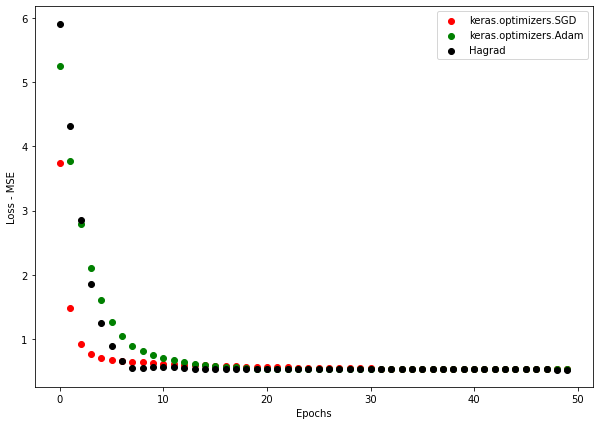

In [15]:
plt.figure(figsize=(10, 7))
plt.scatter(epoch_history, loss_history_sgd, color="r", label="keras.optimizers.SGD") 
plt.scatter(epoch_history, loss_history_adam, color="g", label="keras.optimizers.Adam") 
plt.scatter(epoch_history, loss_history_hagrad, color="k", label="Hagrad")  
plt.xlabel("Epochs")
plt.ylabel("Loss - MSE")
plt.legend()
plt.show()